In [2]:
import torch
import os
from PIL import Image
from utils import ValidationAugmentation
from matplotlib import pyplot as plt
import numpy as np

In [3]:
# Path to the directory where the images are saved
images_dir = "images_AR"

# A list to store the loaded images
loaded_images = []

# Iterate over every file in the directory
for file_name in sorted(os.listdir(images_dir)):
    if file_name.endswith(".png"):
        file_path = os.path.join(images_dir, file_name)
        img = Image.open(file_path)
        loaded_images.append((file_name, img))


In [4]:
# Preprocessing
# Initiate the augmentation class
validation_aug = ValidationAugmentation()

# Normalize all the images to the expected format of the encoder
images = []
images_np = []
for file_name, image_pil in loaded_images:
    processed_tensor = validation_aug(image_pil)  # Apply transforms
    images_np.append(np.array(image_pil.resize((224, 224)) ))
    images.append((processed_tensor))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


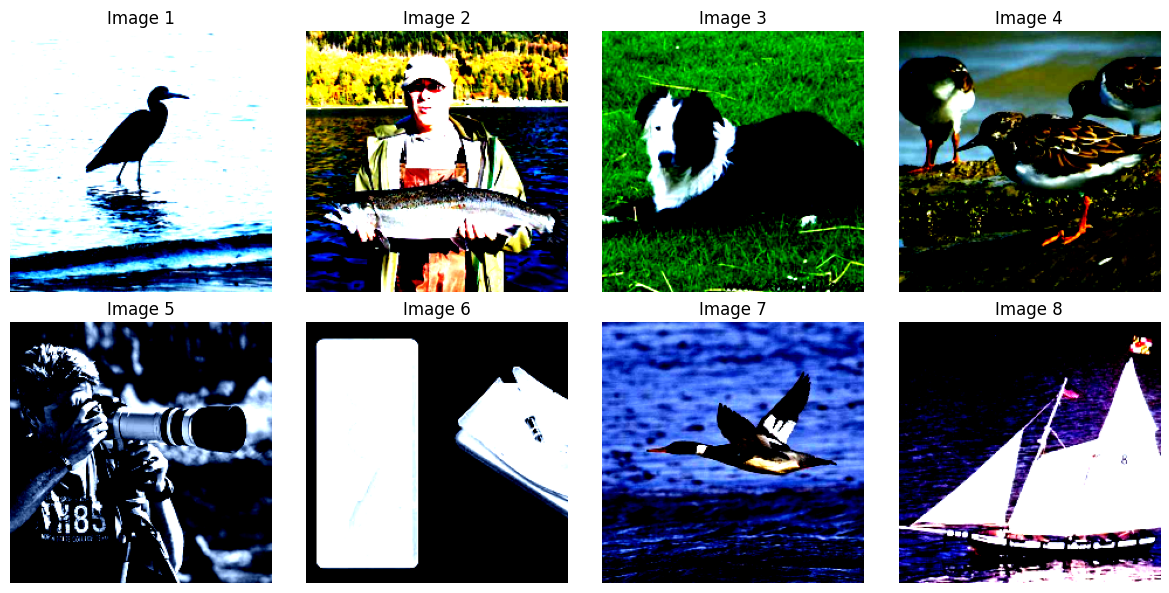

In [5]:
# Plot all 8 images of interest
def plot_images(images, titles=None, rows=2, cols=4):
    """
    Plots a list of images in a grid format.

    Args:
        images: List of PyTorch tensors or NumPy arrays. Each image should be (C, H, W) or (H, W, C).
        titles: Optional list of titles for each image.
        rows: Number of rows in the grid.
        cols: Number of columns in the grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Adjust figure size
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            image = images[i]
            
            # Convert PyTorch tensor to NumPy array
            if isinstance(image, torch.Tensor):
                image = image.detach().cpu()  # Ensure it's on CPU
                if image.ndimension() == 3 and image.shape[0] in [1, 3]:  # (C, H, W)
                    image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
            
            ax.imshow(image, cmap="gray" if image.shape[-1] == 1 else None)
            ax.axis("off")
            
            if titles and i < len(titles):
                ax.set_title(titles[i])
    
    plt.tight_layout()
    plt.show()

# Load and plot the images
titles = [f"Image {i+1}" for i in range(len((images)))] 
plot_images(images, titles=titles)  

## Load Model

In [6]:
from attention_rollout import AttentionRollout

In [7]:
# Specify model name 
dino_100_epochs_path = 'epoch=99-step=1000900.ckpt'
dino_300_epochs_path = 'dino_deitsmall16_pretrain.pth'

In [8]:
# NOTE: The checkpoint with 100 epochs trained had the entire pipeline with heads, etc.
#       The checkpoint with 300 epochs trained only has the student backbone.
#       We will load both and remap the keys from the 100-epoch checkpoint to match the 300-epoch one.
ckpt_100 = torch.load(dino_100_epochs_path, map_location="cpu")
ckpt_300 = torch.load(dino_300_epochs_path, map_location="cpu")

# Extract actual state dict if necessary
ckpt_100_actual = ckpt_100["state_dict"] if "state_dict" in ckpt_100 else ckpt_100
ckpt_300_actual = ckpt_300

ckpt_100_remapped = {}

for old_key, old_value in ckpt_100_actual.items():

    # 1) Keep only keys starting with "student_backbone.vit."
    if not old_key.startswith("student_backbone.vit."):
        continue

    # 2) Remove "student_backbone.vit." prefix
    new_key = old_key.replace("student_backbone.vit.", "")

    # 3) Optionally skip classification/projection heads or other unwanted parts
    #    For instance, skip if ".head." is in the name or we see "mask_token", etc.
    #    This is just one possible example:
    skip_keywords = ["mask_token", "projection_head", "online_classifier", ".head."]
    if any(word in new_key for word in skip_keywords):
        continue

    # 4) If you only want to include keys that also exist in the 300-epoch checkpoint:
    if new_key not in ckpt_300_actual:
        continue

    # 5) Keep the key
    ckpt_100_remapped[new_key] = old_value

# Finally, save the filtered/remapped checkpoint
torch.save(ckpt_100_remapped, "ckpt_100.pth")
print("Saved remapped checkpoint with student backbone only.")


Saved remapped checkpoint with student backbone only.


In [52]:
DINO_100 = AttentionRollout(checkpoint_path='ckpt_100.pth', head_fusion='max')
DINO_300 = AttentionRollout(checkpoint_path='dino_deitsmall16_pretrain.pth', head_fusion='max')

Model weights loaded from ckpt_100.pth
Model weights loaded from dino_deitsmall16_pretrain.pth


In [53]:
images_tensor = torch.stack(images)
attention_rollout_DINO_100 = DINO_100(images_tensor)
attention_rollout_DINO_300 = DINO_300(images_tensor)

In [54]:
from utils import reshape_attention_rollout, show_mask_on_image
attention_rollout_100 = reshape_attention_rollout(attention_rollout_DINO_100[0].unsqueeze(0))

In [55]:
attention_rollout_DINO_100.shape

torch.Size([8, 197])

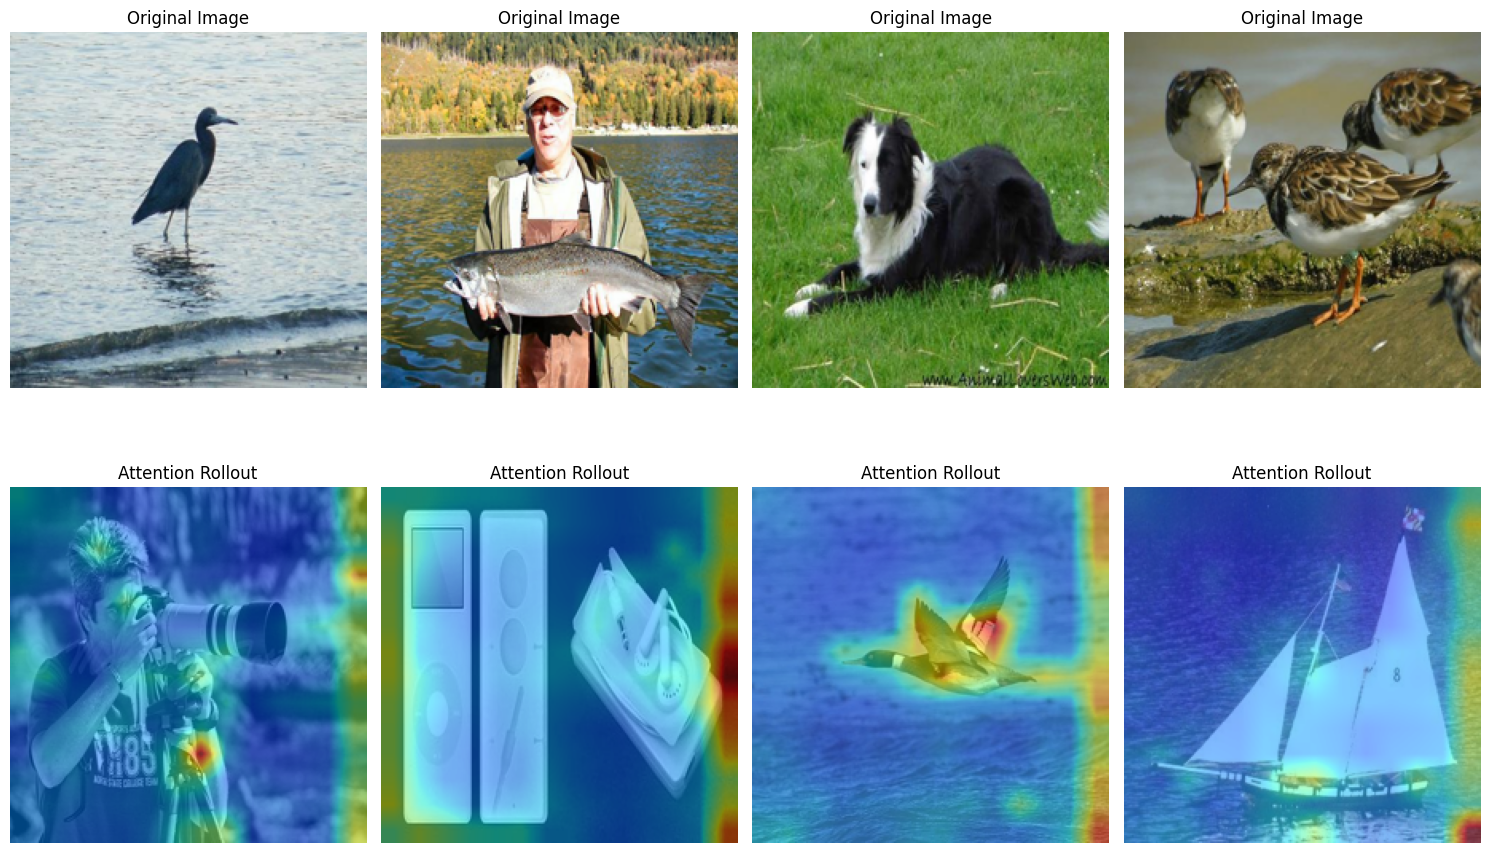

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Suppose you have 8 images in images_np and images_tensor
num_images = 8

# Create a 2x4 grid (2 rows, 4 columns) for a total of 8 subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i in range(num_images):
    # We'll place image i into row = i // 4, col = i % 4
    row = i // 4
    col = i % 4
    
    np_img = images_np[i]
    input_tensor = images_tensor[i].unsqueeze(0)
    
    # Compute attention and reshape/resize it
    attention_rollout = DINO_100(input_tensor)
    attention_rollout = reshape_attention_rollout(attention_rollout)
    attention_resized = cv2.resize(attention_rollout,
                                   (np_img.shape[1], np_img.shape[0]))
    
    # Generate the masked image
    attention_masked_img = show_mask_on_image(np_img[:,:,:3], attention_resized)
    
    # For the *top* row, show the original image
    if row == 0:
        axes[row, col].imshow(np_img)
        axes[row, col].set_title("Original Image")
        axes[row, col].axis("off")
    else:
        # For the *bottom* row, show the attention rollout
        axes[row, col].imshow(attention_masked_img)
        axes[row, col].set_title("Attention Rollout")
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()


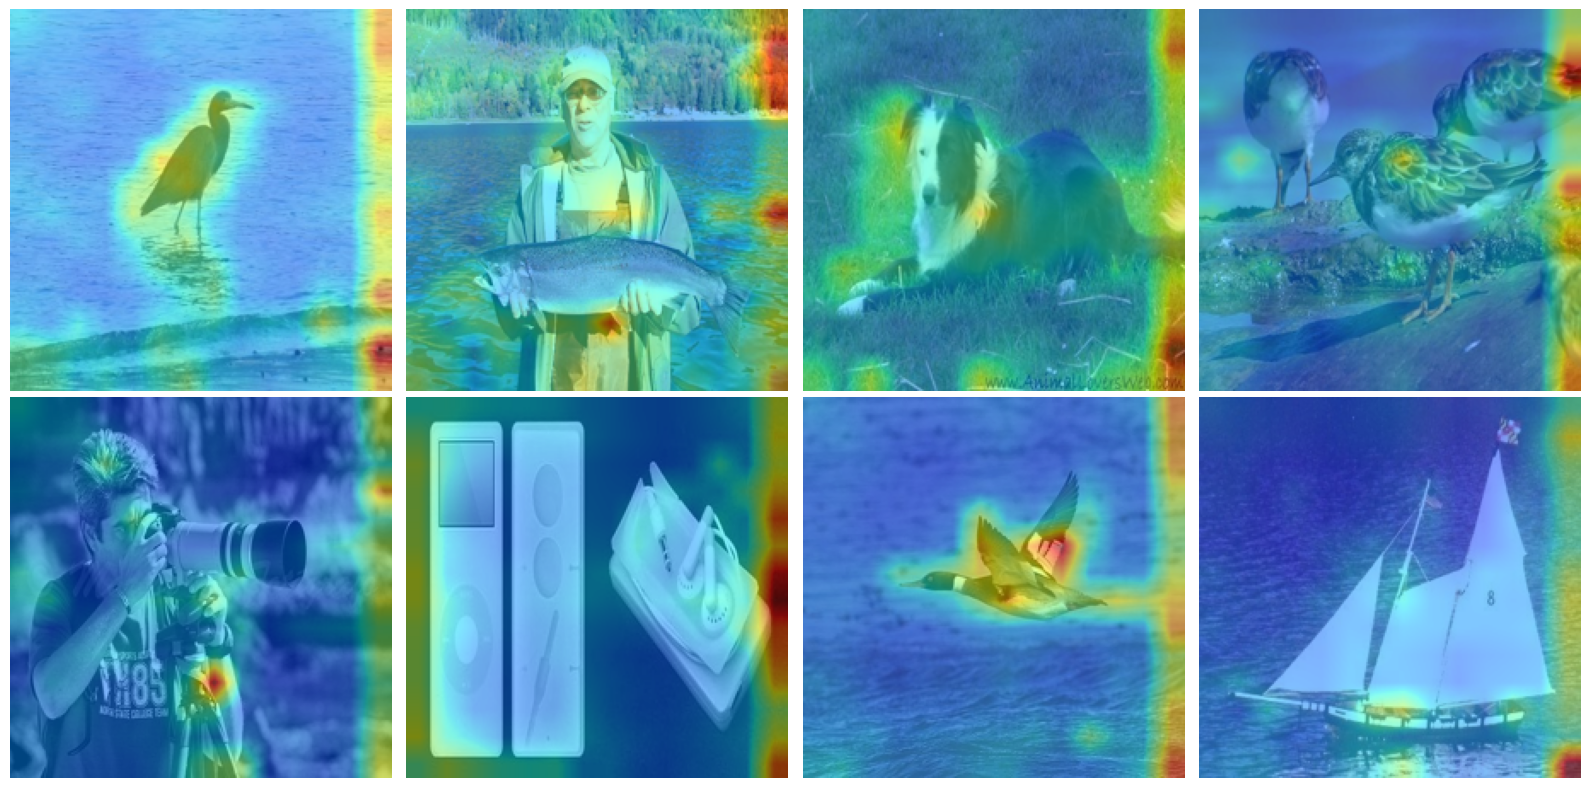

In [57]:
# Create a 2x4 grid for the 8 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
#fig.suptitle("Attention Rollout with DINO after 100 Epochs", fontsize=16)

num_images = len(images)  # should be 8

for i in range(num_images):
    row = i // 4
    col = i % 4
    
    np_img = images_np[i]
    input_tensor = images_tensor[i].unsqueeze(0)
    
    # Compute attention and reshape
    attention_rollout = DINO_100(input_tensor)
    attention_rollout = reshape_attention_rollout(attention_rollout)
    
    # Resize to match the original image size
    attention_resized = cv2.resize(attention_rollout,
                                   (np_img.shape[1], np_img.shape[0]))
    
    # Create the attention-masked image
    attention_masked_img = show_mask_on_image(np_img[:,:,:3], attention_resized)
    
    # Plot the attention image
    axes[row, col].imshow(attention_masked_img)
    axes[row, col].axis("off")

plt.tight_layout()
plt.savefig(dpi=300, fname="attention_rollout_dino_100.png")


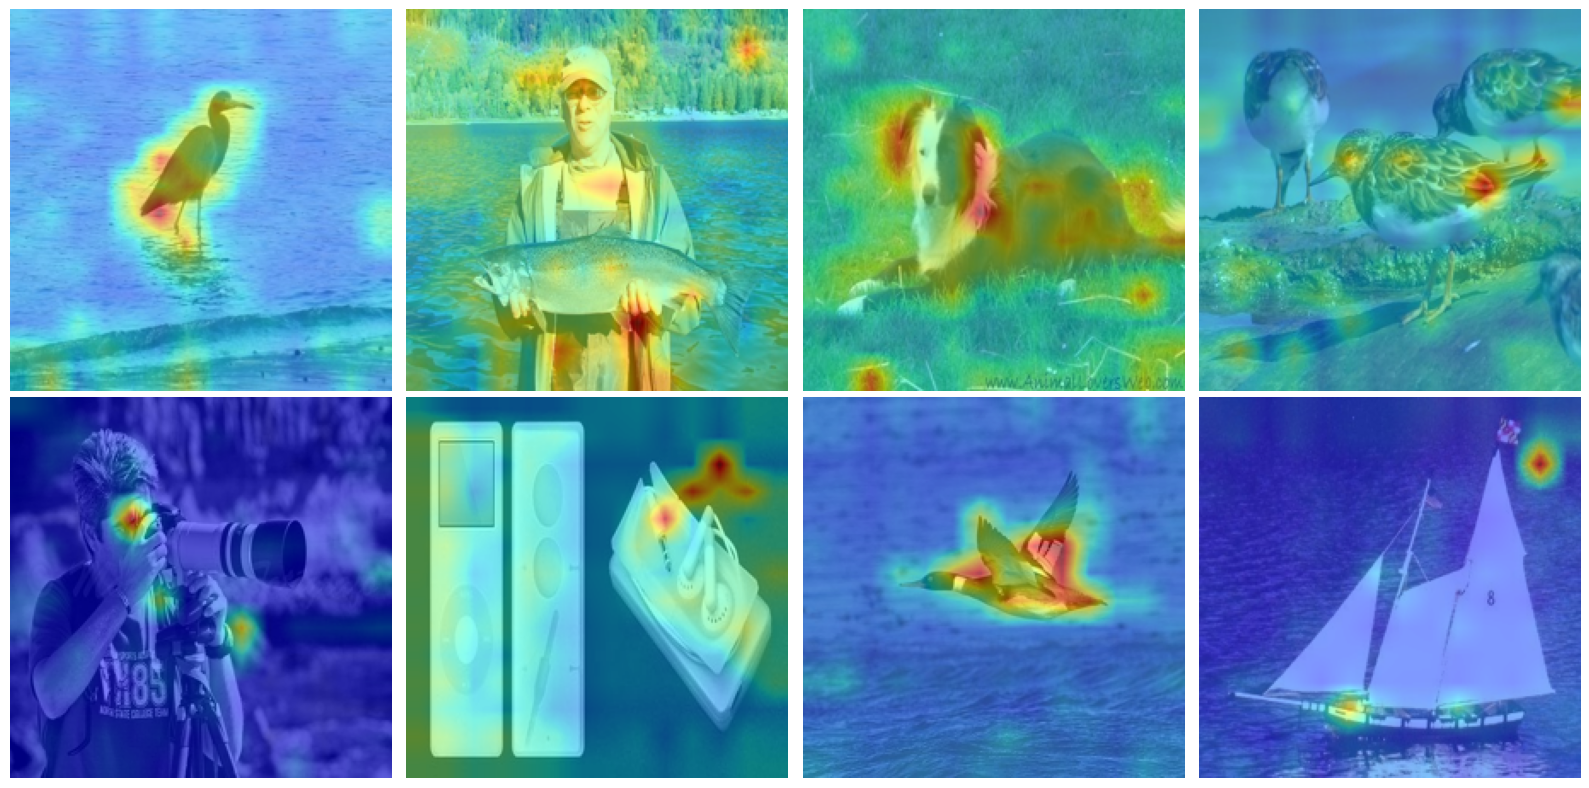

In [58]:
# Create a 2x4 grid for the 8 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
#fig.suptitle("Attention Rollout with DINO after 300 Epochs", fontsize=16)

num_images = len(images)  # should be 8

for i in range(num_images):
    row = i // 4
    col = i % 4
    
    np_img = images_np[i]
    input_tensor = images_tensor[i].unsqueeze(0)
    
    # Compute attention and reshape
    attention_rollout = DINO_300(input_tensor)
    attention_rollout = reshape_attention_rollout(attention_rollout)
    
    # Resize to match the original image size
    attention_resized = cv2.resize(attention_rollout,
                                   (np_img.shape[1], np_img.shape[0]))
    
    # Create the attention-masked image
    attention_masked_img = show_mask_on_image(np_img[:,:,:3], attention_resized)
    
    # Plot the attention image
    axes[row, col].imshow(attention_masked_img)
    axes[row, col].axis("off")

plt.tight_layout()
plt.savefig(dpi=300, fname="attention_rollout_dino_300.png")


In [41]:
carp_20  = AttentionRollout('CARP_ViT_100_epochs_000000000020.pth', head_fusion='max')

Model weights loaded from CARP_ViT_100_epochs_000000000020.pth


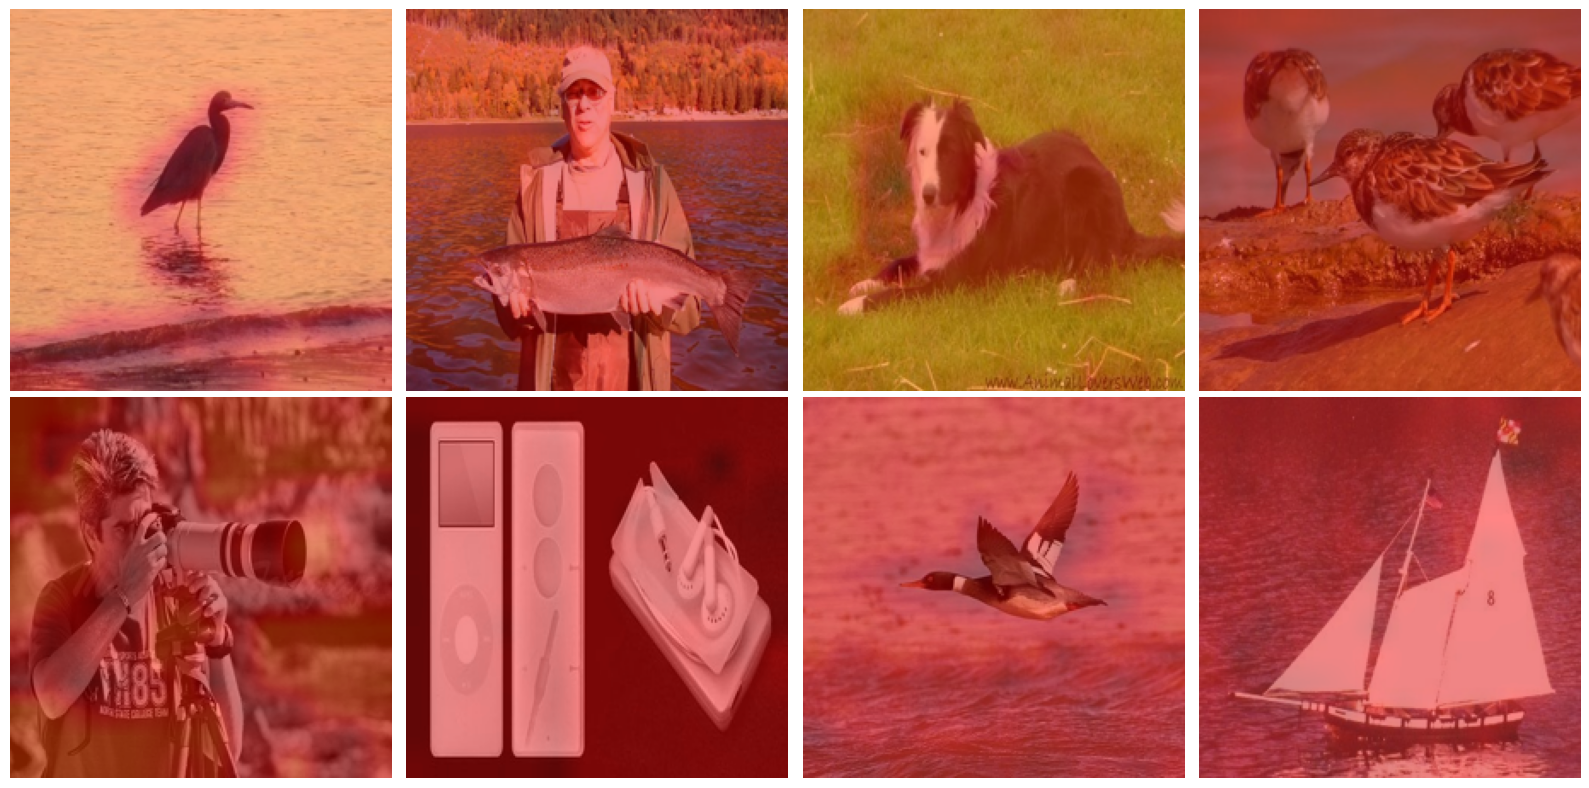

In [42]:
# Create a 2x4 grid for the 8 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
#fig.suptitle("Attention Rollout with CARP after 20 Epochs", fontsize=16)

num_images = len(images)  # should be 8

for i in range(num_images):
    row = i // 4
    col = i % 4
    
    np_img = images_np[i]
    input_tensor = images_tensor[i].unsqueeze(0)
    
    # Compute attention and reshape
    attention_rollout = carp_20(input_tensor)
    attention_rollout = reshape_attention_rollout(attention_rollout)
    
    # Resize to match the original image size
    attention_resized = cv2.resize(attention_rollout,
                                   (np_img.shape[1], np_img.shape[0]))
    
    # Create the attention-masked image
    attention_masked_img = show_mask_on_image(np_img[:,:,:3], attention_resized)
    
    # Plot the attention image
    axes[row, col].imshow(attention_masked_img)
    axes[row, col].axis("off")

plt.tight_layout()
plt.savefig(dpi=300, fname="attention_rollout_carp_20.png")


## Aggregation Strategy


Model weights loaded from CARP_ViT_100_epochs_000000000020.pth
Model weights loaded from CARP_ViT_100_epochs_000000000020.pth
Model weights loaded from CARP_ViT_100_epochs_000000000020.pth


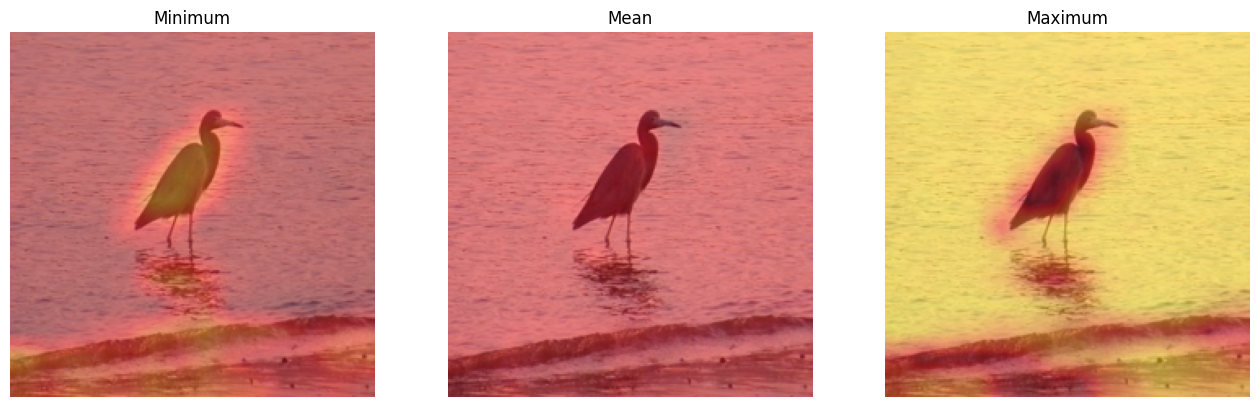

In [40]:
CARP_24_min = AttentionRollout('CARP_ViT_100_epochs_000000000020.pth',head_fusion='min')
CARP_24_mean = AttentionRollout('CARP_ViT_100_epochs_000000000020.pth',head_fusion='mean')
CARP_24_max = AttentionRollout('CARP_ViT_100_epochs_000000000020.pth', head_fusion='max')

CARP_20_Rollout = [CARP_24_min, CARP_24_mean, CARP_24_max]

fig, axes = plt.subplots(1, 3, figsize=(16, 8))

image_index = 0
np_img = images_np[image_index]
input_tensor = images_tensor[image_index].unsqueeze(0)

for i in range(len(CARP_20_Rollout)):
    # Compute attention and reshape
    attention_rollout = CARP_20_Rollout[i](input_tensor)
    attention_rollout = reshape_attention_rollout(attention_rollout)

    # Resize to match the original image size
    attention_resized = cv2.resize(attention_rollout,
                                   (np_img.shape[1], np_img.shape[0]))

    # Create the attention-masked image
    attention_masked_img = show_mask_on_image(np_img[:, :, :3], attention_resized)

    # Plot the attention image
    axes[i].imshow(attention_masked_img)
    axes[i].axis("off")

# Set titles for each subplot
axes[0].set_title("Minimum")
axes[1].set_title("Mean")
axes[2].set_title("Maximum")

plt.savefig(dpi=300, fname="AR_strategy_carp_20.png")

Model weights loaded from dino_deitsmall16_pretrain.pth
Model weights loaded from dino_deitsmall16_pretrain.pth
Model weights loaded from dino_deitsmall16_pretrain.pth


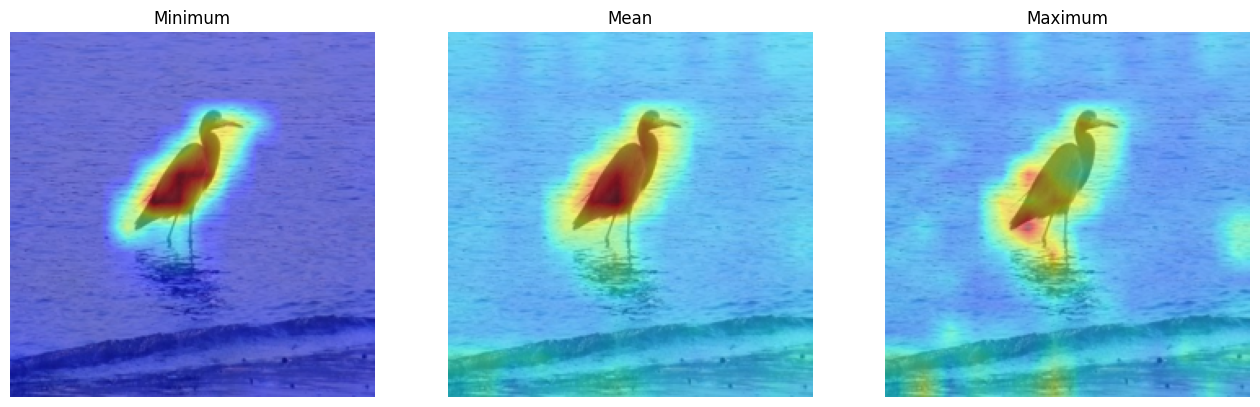

In [ ]:
DINO_300_min = AttentionRollout(dino_300_epochs_path, head_fusion='min')
DINO_300_mean = AttentionRollout(dino_300_epochs_path, head_fusion='mean')
DINO_300_max = AttentionRollout(dino_300_epochs_path, head_fusion='max')

DINO_300_Rollout = [DINO_300_min, DINO_300_mean, DINO_300_max]

fig, axes = plt.subplots(1, 3, figsize=(16, 8))

np_img = images_np[0]
input_tensor = images_tensor[0].unsqueeze(0)

for i in range(len(DINO_300_Rollout)):
    # Compute attention and reshape
    attention_rollout = DINO_300_Rollout[i](input_tensor)
    attention_rollout = reshape_attention_rollout(attention_rollout)

    # Resize to match the original image size
    attention_resized = cv2.resize(attention_rollout,
                                   (np_img.shape[1], np_img.shape[0]))

    # Create the attention-masked image
    attention_masked_img = show_mask_on_image(np_img[:, :, :3], attention_resized)

    # Plot the attention image
    axes[i].imshow(attention_masked_img)
    axes[i].axis("off")

# Set titles for each subplot
axes[0].set_title("Minimum")
axes[1].set_title("Mean")
axes[2].set_title("Maximum")

plt.savefig(dpi=300, fname="AR_strategy_DINO_300.png")
